In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import cupy as cp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
data = np.load("/content/drive/MyDrive/Deep_learning/Tamrin2/VGGFeature/train_features.npz")
X_train = data["features"]
y_train = data["labels"]
data = np.load("/content/drive/MyDrive/Deep_learning/Tamrin2/VGGFeature/test_features.npz")
X_test = data["features"]
y_test = data["labels"]

In [3]:
del data

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = models.vgg16(pretrained=True)
classifier = vgg.classifier

num_classes = 10
classifier[-1] = nn.Linear(4096, num_classes)

model = nn.Sequential(
    classifier
).to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 94.6MB/s]


In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100
train_losses = []
val_accuracies = []
inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
labels =  torch.tensor(y_train, dtype=torch.long).to(device)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
  labels =  torch.tensor(y_train, dtype=torch.long).to(device)

  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  running_loss += loss.item()
  train_losses.append(running_loss)

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    inputs_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    labels_test =  torch.tensor(y_test, dtype=torch.long).to(device)
    outputs = model(inputs_test)
    preds = torch.argmax(outputs, dim=1)
    correct += (preds == labels_test).sum().item()
    total += labels_test.size(0)
  acc = correct / total
  val_accuracies.append(acc)
  print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Val Acc: {acc:.4f}")

Epoch 1, Loss: 2.3272, Val Acc: 0.2285
Epoch 2, Loss: 2.2037, Val Acc: 0.2982
Epoch 3, Loss: 2.0917, Val Acc: 0.3434
Epoch 4, Loss: 1.9808, Val Acc: 0.3672
Epoch 5, Loss: 1.8646, Val Acc: 0.3943
Epoch 6, Loss: 1.7515, Val Acc: 0.4216
Epoch 7, Loss: 1.6360, Val Acc: 0.4471
Epoch 8, Loss: 1.5410, Val Acc: 0.4733
Epoch 9, Loss: 1.4389, Val Acc: 0.4988
Epoch 10, Loss: 1.3438, Val Acc: 0.5256
Epoch 11, Loss: 1.2622, Val Acc: 0.5434
Epoch 12, Loss: 1.1864, Val Acc: 0.5607
Epoch 13, Loss: 1.1082, Val Acc: 0.5765
Epoch 14, Loss: 1.0361, Val Acc: 0.5984
Epoch 15, Loss: 0.9703, Val Acc: 0.6100
Epoch 16, Loss: 0.9050, Val Acc: 0.6250
Epoch 17, Loss: 0.8391, Val Acc: 0.6410
Epoch 18, Loss: 0.7737, Val Acc: 0.6533
Epoch 19, Loss: 0.7119, Val Acc: 0.6611
Epoch 20, Loss: 0.6620, Val Acc: 0.6702
Epoch 21, Loss: 0.6058, Val Acc: 0.6838
Epoch 22, Loss: 0.5505, Val Acc: 0.6929
Epoch 23, Loss: 0.5033, Val Acc: 0.7018
Epoch 24, Loss: 0.4567, Val Acc: 0.7070
Epoch 25, Loss: 0.4131, Val Acc: 0.7130
Epoch 26,

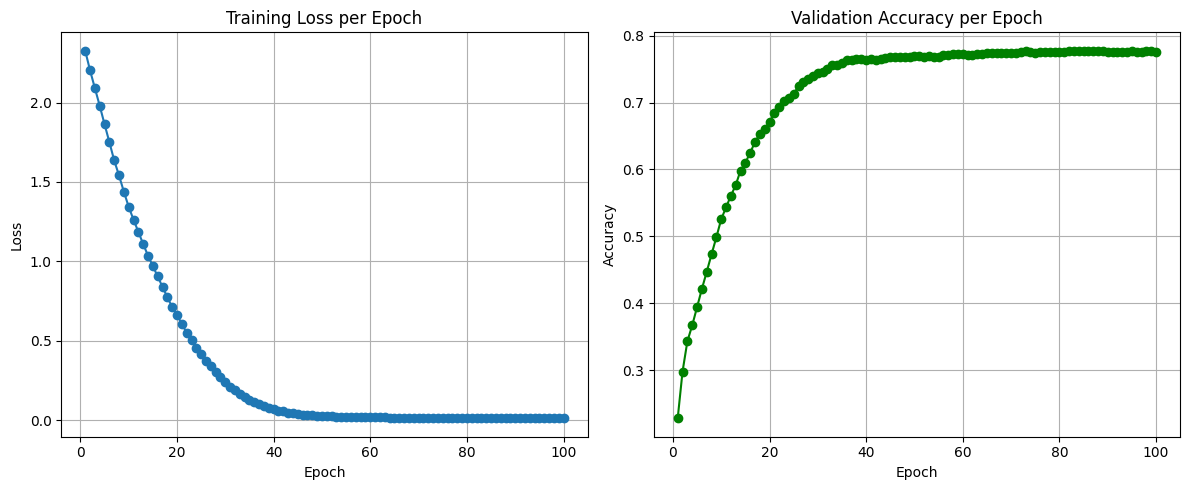

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', color='green')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


🔍 Final Evaluation Metrics:
Accuracy : 0.7756
Precision: 0.7768
Recall   : 0.7756
F1 Score : 0.7758


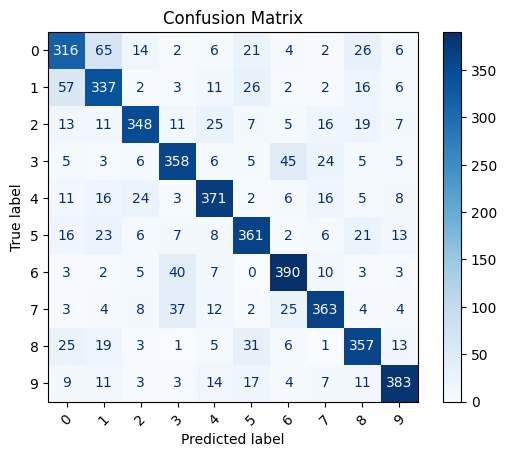

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

inputs_test = torch.tensor(X_test, dtype=torch.float32).to(device)
labels_test = torch.tensor(y_test, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(inputs_test)
    preds = torch.argmax(outputs, dim=1)

y_true = labels_test.cpu().numpy()
y_pred = preds.cpu().numpy()
# Code from ChatGpt for clean calculation of metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n🔍 Final Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")


cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()